## 1. Background

## 2. Data Cleaning 

The first thing to check is whether there are any apparently wrong records. According to Siri's equation, there is a linear relation between the percentage of body fat and the reciprocal of density, so we draw the following plot (1/DENSITY vs. BODYFAT).

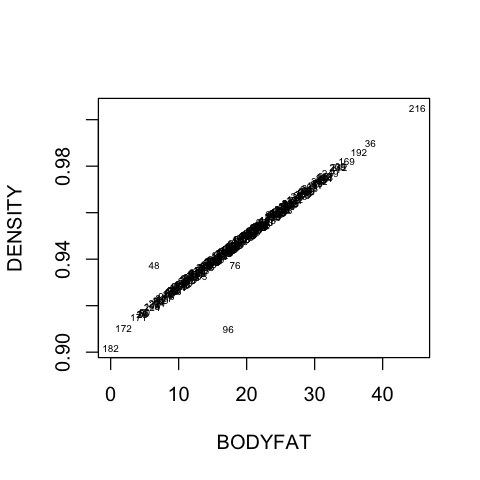

In [105]:
bodyfat <- read.table('../data/BodyFat.csv',header = T,sep = ',')
options(repr.plot.width=4, repr.plot.height=4)
plot(bodyfat$BODYFAT,1/bodyfat$DENSITY,type = 'n',xlab="BODYFAT",ylab="DENSITY")
text(bodyfat$BODYFAT,1/bodyfat$DENSITY,bodyfat$IDNO,cex=0.5)

The 182th, 96th, 76th and 48th records should be dropped since we can't decide if we should believe BODYFAT or DENSITY or neither. According to the BMI equation (BMI=Weight/Height^2), similarly, we draw the following plots to find anomalies (WEIGHT/HEIGHT^2 vs. ADIPOSITY). In order to make a clearer display, the plot on the left includes 42th record, and the one on the right excludes it.

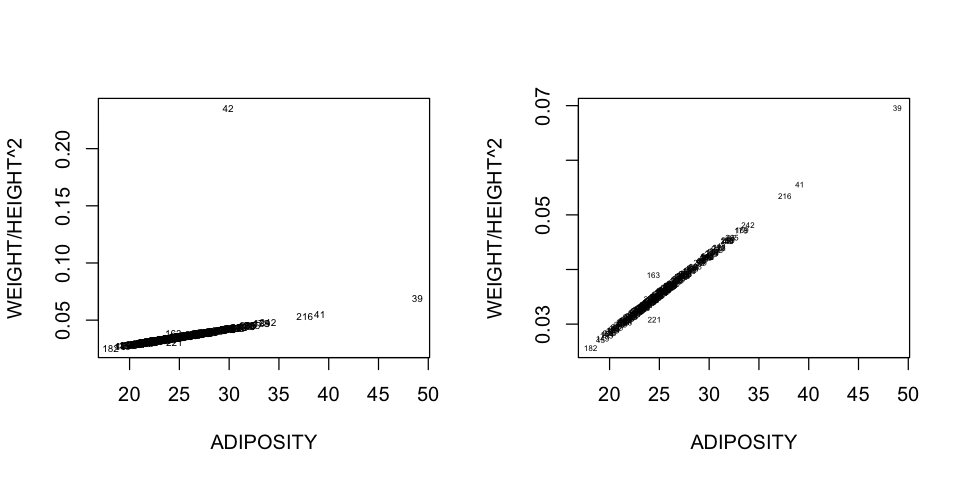

In [86]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,bodyfat$IDNO,cex=0.5)
plot(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,bodyfat[-42,]$IDNO,cex=0.4)

We can see that No. 42, 163 and 221 are far away from the theoretical line. We correct the mistakes using their height and adiposity. For 39th and 41th records, they are far away from the majority, we need further study (which will be discussed later) to decide whether they are valid or not.

In [87]:
bodyfat[42,'HEIGHT'] <- sqrt(bodyfat[42,'WEIGHT']/bodyfat[42,'ADIPOSITY']*703)
bodyfat[162,'HEIGHT'] <- sqrt(bodyfat[162,'WEIGHT']/bodyfat[162,'ADIPOSITY']*703) 
bodyfat[220,'HEIGHT'] <- sqrt(bodyfat[220,'WEIGHT']/bodyfat[220,'ADIPOSITY']*703) 

We then check whether there are any unusual values of the response (i.e. BODYFAT). Judged from the quartiles and the boxplot, there are two skeptical records (No. 172 and 216).

,Quartiles
,<dbl>
0%,1.9
25%,13.1
50%,19.1
75%,24.6
100%,45.1


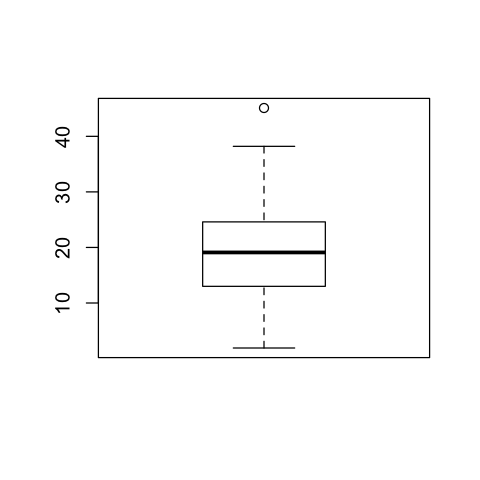

In [106]:
options(repr.plot.width=4, repr.plot.height=4)
boxplot(bodyfat[-c(182,96,76,48),]$BODYFAT)
data.frame(Quartiles=quantile(bodyfat[-c(182,96,76,48),]$BODYFAT))

In [107]:
bodyfat[c(172,216),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
172,172,1.9,1.0983,35,125.75,65.5,20.6,34.0,90.8,75.0,89.2,50.0,34.8,22.0,24.8,25.9,16.9
216,216,45.1,0.9950,51,219.00,64.0,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


According to American Council on Exercise, the minimum bodyfat is 2$\%$. 45.1$\%$ is a possible value based on our research. Therefore, we keep both of them. Next, we detect outliers for explanatory variables. Intuitively, if some record is far from the majority, it may be wrong. Even it is a correct record, it may not come from the same population we are interested in. It is difficult to plot high dimension scatter plot so here we look at pairwise scatter plots.

In [125]:
require("MVA")
require("biwt")

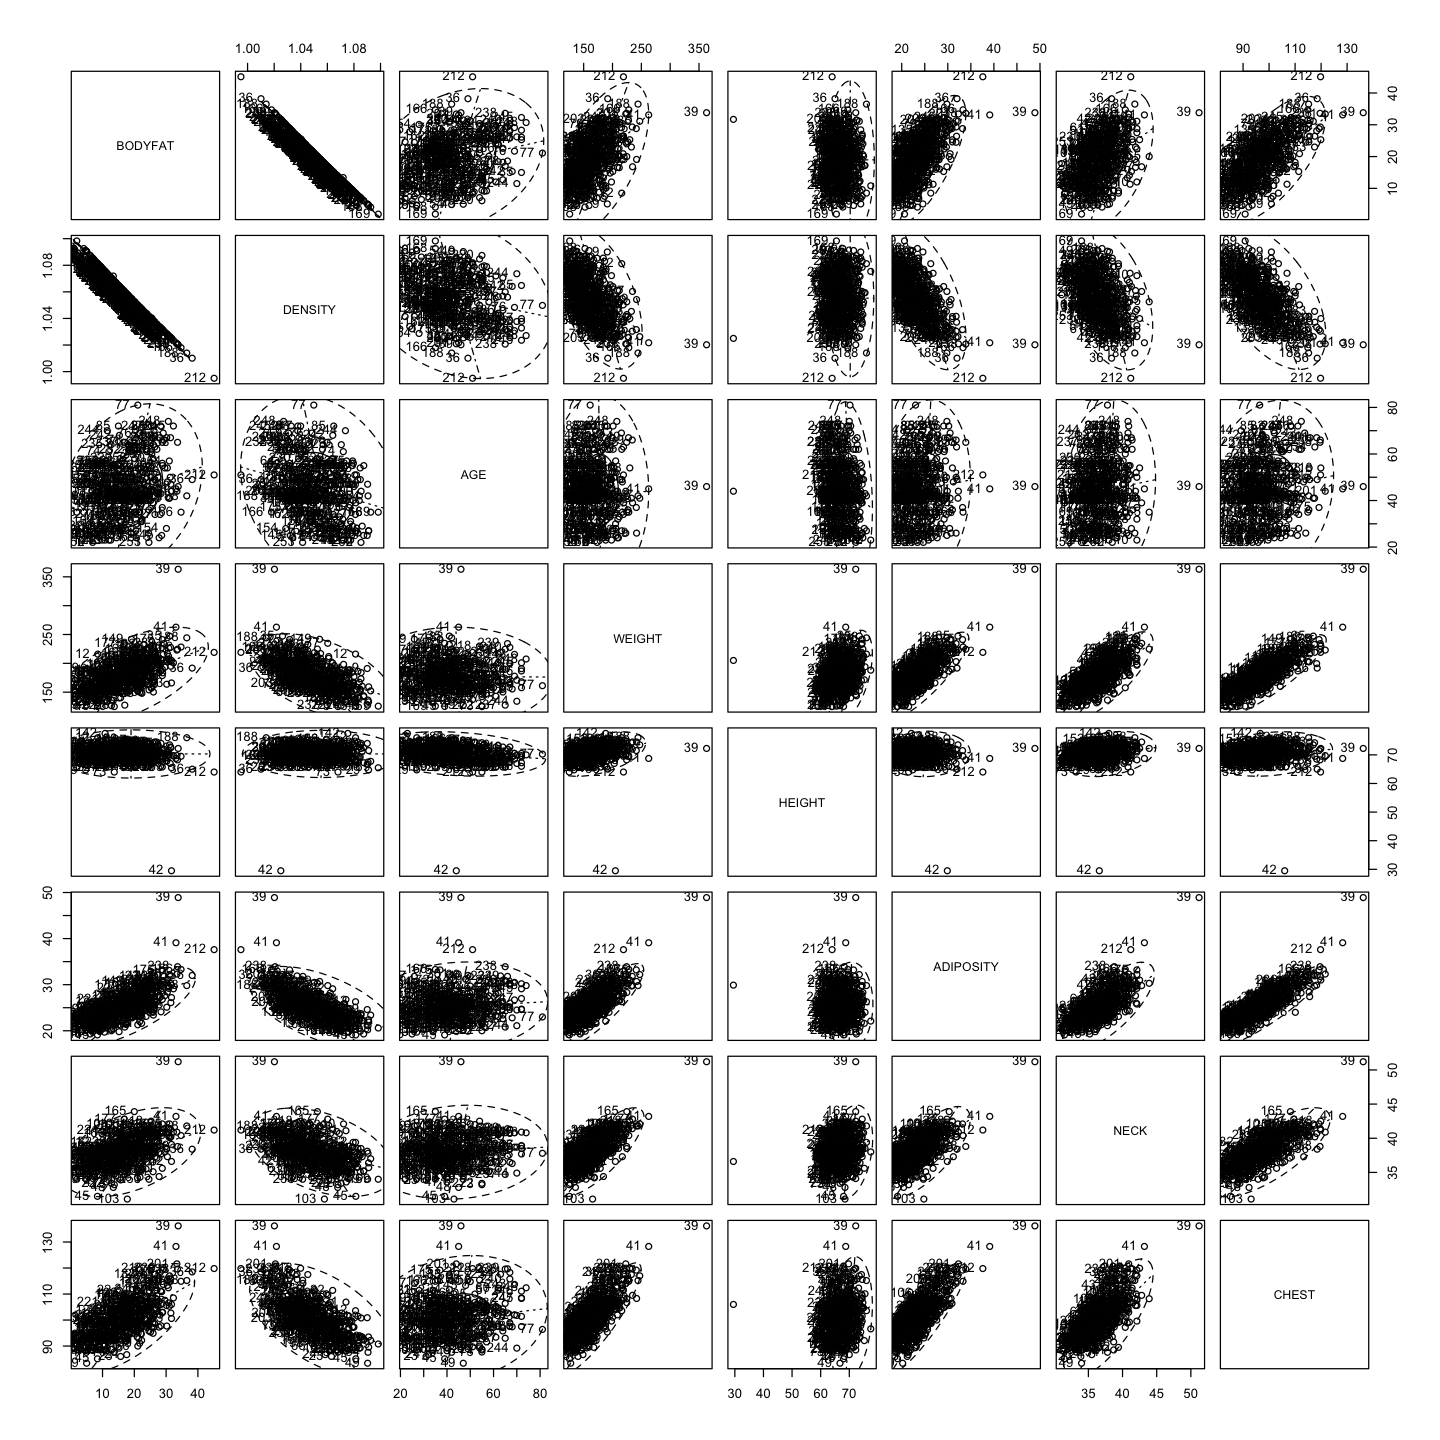

In [111]:
options(repr.plot.width=12, repr.plot.height=12)
pairs(bodyfat[-c(48,76,96,182),2:9], 
      panel = function(x,y, ...) {
        text(x, y, IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })

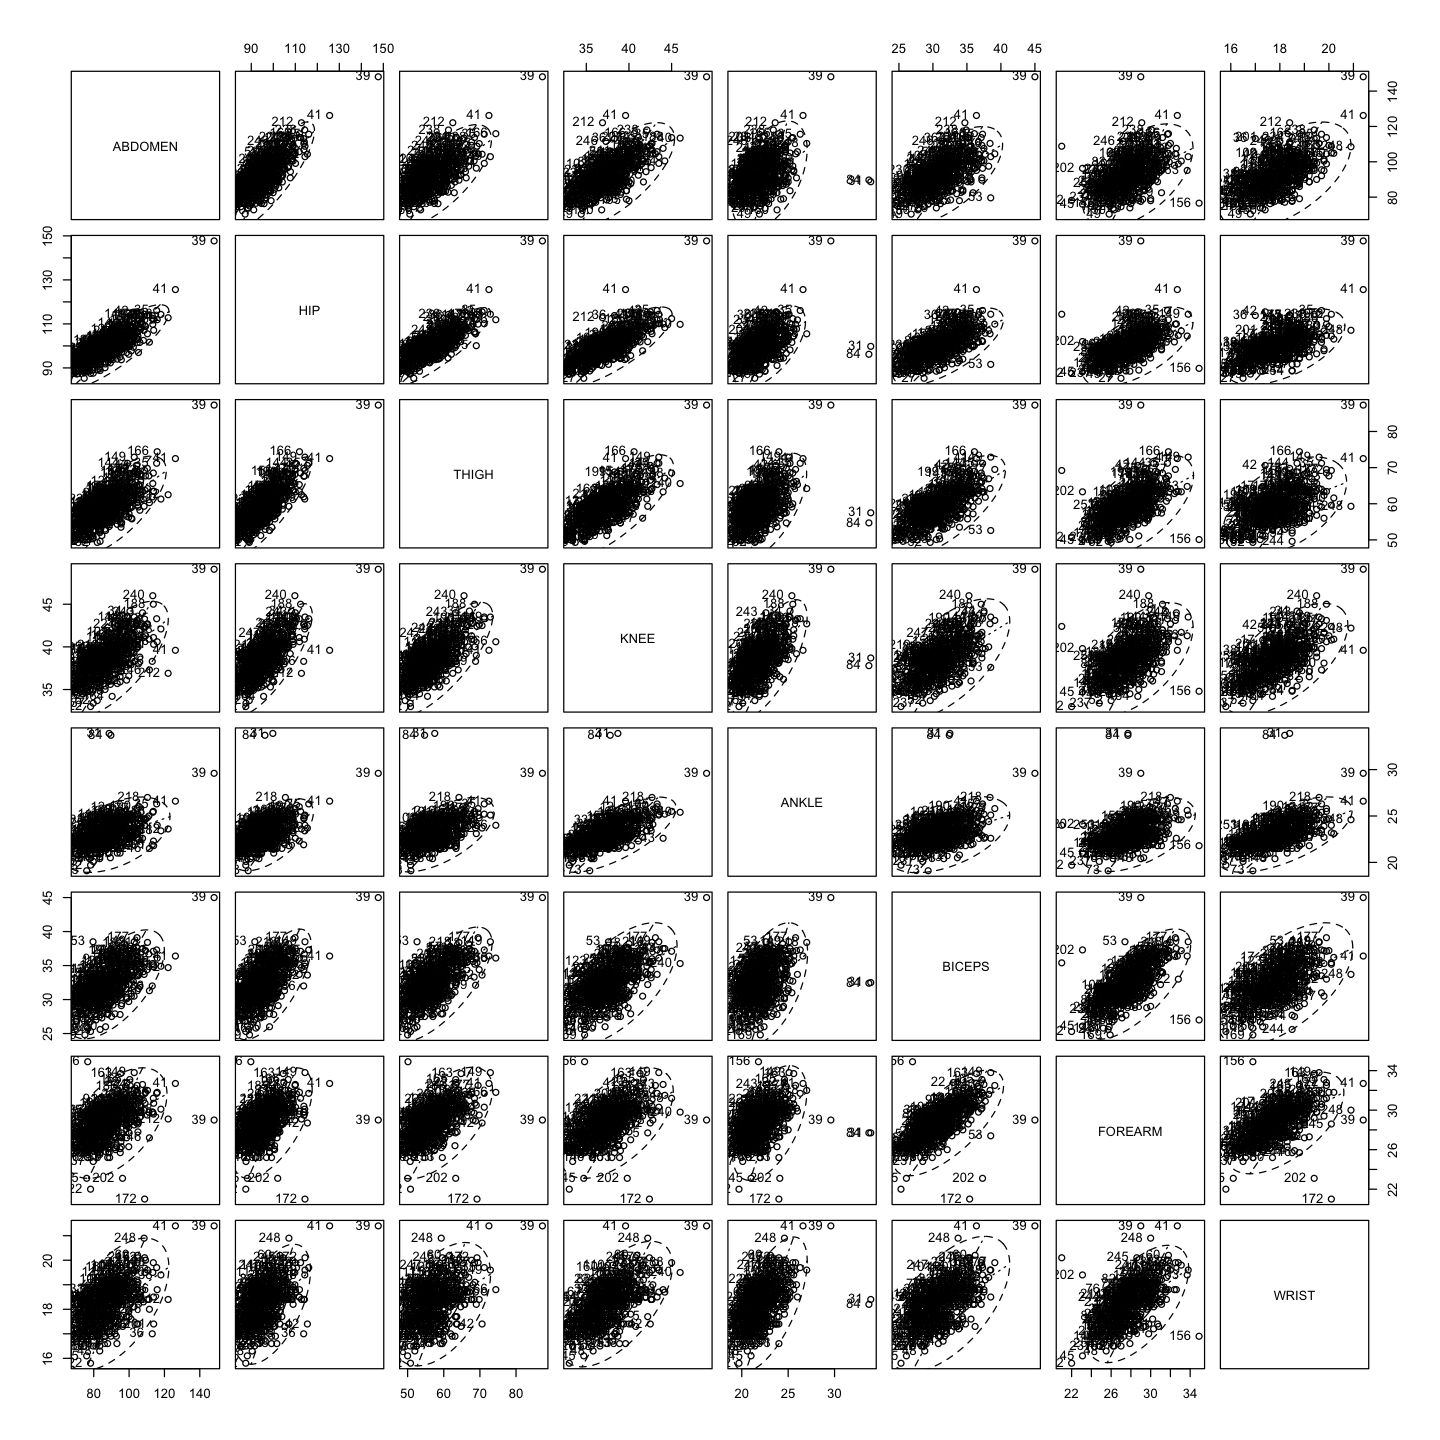

In [113]:
options(repr.plot.width=12, repr.plot.height=12)
pairs(bodyfat[-c(48,76,96,182),10:17], 
      panel = function(x,y, ...) {
        text(x, y, IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })

The 39, 41 and 212 always lay out of the dashed line. We will check them to see if there is any mistake.

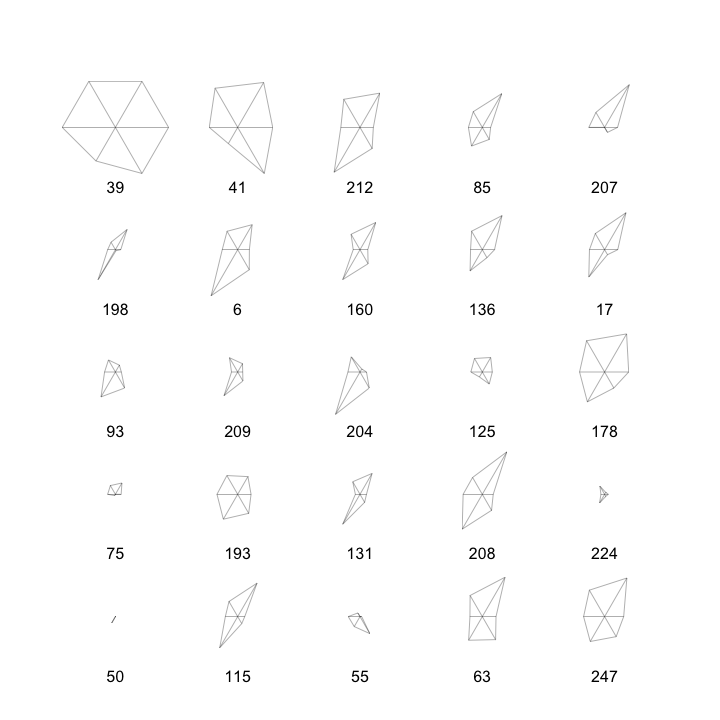

In [114]:
set.seed(2)
x <- sample(1:252,23)
y <- x[!x %in% c(48,76,96,182)]
options(repr.plot.width=6, repr.plot.height=6)
subdata <- bodyfat[unique(c(39,41,212,y)),c('IDNO',"ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')]
stars(subdata[,c("ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')],
      nrow=5,ncol=5,labels=subdata$IDNO)

The first 3 hexagon are the suspects, the vertexes of hexagon represent a man's ADIPOSITY, BODYFAT, CHEST, NECK, HEIGHT and WRIST. We can see 39 and 41 are two big guys in almost every aspect and is significantly different from others, so we delete them. 212 has a similar 'shape' with most of other people so we think it is also a correct record. Besides, we check the extreme values for each variables, they are among the reasonable rangen, so we keep them all.

So far, we have deleted No.39, 41, 48, 76, 96, 182 records. Next, we fit a full linear regression model to make further inspection. 

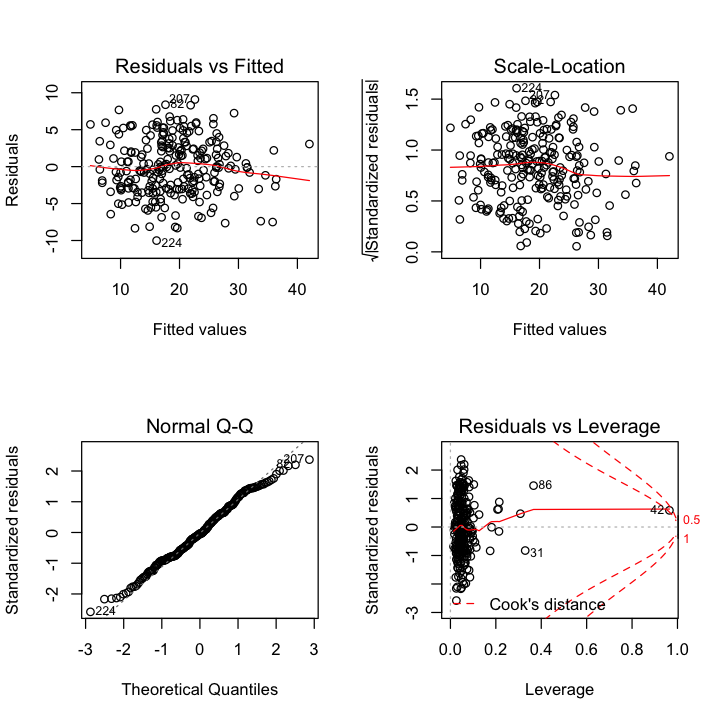

In [123]:
options(repr.plot.width=6, repr.plot.height=6)
bodyfat$IDNO=NULL
lm.dirte <- lm(BODYFAT ~ ., data=subset(bodyfat[-c(39,41,48,76,96,182),],select=-DENSITY))
par(mfcol=c(2,2))
plot(lm.dirte)

Judged from the residual plots, there are no obvious outliers any more, but high-leverage points exist. Then we detect influential observations by cook's distance and leverage. (The red lines are thresholds based on rules of thumb.)

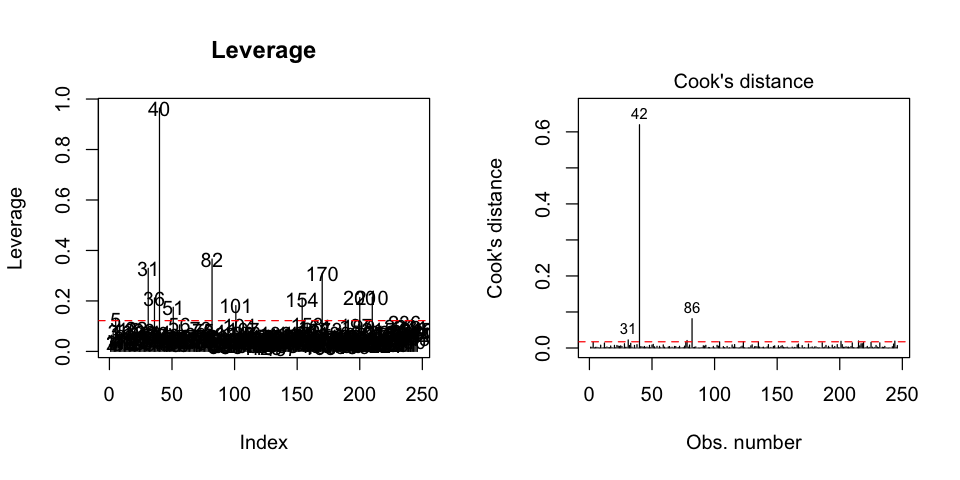

In [124]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfcol=c(1,2))
lm.dirte.hats = hatvalues(lm.dirte)
plot(lm.dirte.hats, type = "h", ylab = "Leverage",main="Leverage") 
text(lm.dirte.hats, cex = 1)
abline(h=2*15/(252-6), lty = 2,col=2) 
plot(lm.dirte, which=4)
abline( h = 4/(252-15-6),lty=2 ,col=2)

No. 31 is an influential observation. We take a close look at it and find nothing seems wrong about it, so we choose to keep it. 

Finally, we save the dataset after cleaning into the "cleanfile.csv" file.

In [ ]:
write.csv(bodyfat,"../data/cleanfile.csv")